In [1]:
import os
from PIL import Image
import torch
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sentencepiece as spm
import zipfile
import requests
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform
import timm
import torch.nn as nn
import torch.nn.init as init
import torchvision.models as models
from tqdm import tqdm

os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

In [2]:
# Set the ZIP file download URL
zip_file_url = 'https://drive.usercontent.google.com/download?id=1FMVcFM78XZE1KE1rIkGBpCdcdI58S1LB&export=download&authuser=0&confirm=t&uuid=bf963761-6285-431e-8a17-f9ea4d1f01ce&at=APZUnTUZF79_K61JMipu1xrm0xIi%3A1712588788876'

# Set the directory to save the extracted files
extract_dir = '/content'

# Create the extract directory if it doesn't exist
if not os.path.exists(extract_dir):
    os.makedirs(extract_dir)

# Download the ZIP file
print('Downloading dataset ZIP file...')
response = requests.get(zip_file_url)
with open('/content/dataset.zip', 'wb') as f:
    f.write(response.content)

# Extract the ZIP file
print('Extracting dataset...')
with zipfile.ZipFile('/content/dataset.zip', 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

Extracting dataset...


In [3]:
#Loading the captions
train_captions = pd.read_csv('/content/custom_captions_dataset/train.csv')
train_captions.drop('Unnamed: 0', axis=1, inplace=True)

val_captions = pd.read_csv('/content/custom_captions_dataset/val.csv')
val_captions.drop('Unnamed: 0', axis=1, inplace=True)

test_captions = pd.read_csv('/content/custom_captions_dataset/test.csv')
test_captions.drop('Unnamed: 0', axis=1, inplace=True)

print(train_captions.head())

train_captions = train_captions['caption'].values
val_captions = val_captions['caption'].values
test_captions = test_captions['caption'].values

# Writing the captions to a text file
with open('/content/custom_captions_dataset/train_captions.txt', 'w') as f:
    for caption in train_captions:
        #Removing any \n from end
        caption = caption.replace('\n', '')
        f.write(caption + '\n')

with open('/content/custom_captions_dataset/val_captions.txt', 'w') as f:
    for caption in val_captions:
        #Removing any \n from end
        caption = caption.replace('\n', '')
        f.write(caption + '\n')

with open('/content/custom_captions_dataset/test_captions.txt', 'w') as f:
    for caption in test_captions:
        #Removing any \n from end
        caption = caption.replace('\n', '')
        f.write(caption + '\n')

      filename                                            caption
0  train_1.jpg  A white round plate is on a table with a plast...
1  train_2.jpg  There are four small pizzas on a brown wooden ...
2  train_3.jpg  A black and white cat is sitting in a white ch...
3  train_4.jpg  A boy is practicing his skateboard moves outsi...
4  train_5.jpg  Two brown horses are standing together outside...


In [4]:
#Training the sentence piece model
spm.SentencePieceTrainer.train(input='/content/custom_captions_dataset/train_captions.txt', model_prefix='spm', model_type='bpe', character_coverage=1.0, pad_id = 3)

sp = spm.SentencePieceProcessor(model_file='spm.model')

# Printing the vocabulary and size
print('Vocabulary size:', sp.get_piece_size())

Vocabulary size: 8000


sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: /content/custom_captions_dataset/train_captions.txt
  input_format: 
  model_prefix: spm
  model_type: BPE
  vocab_size: 8000
  self_test_sample_size: 0
  character_coverage: 1
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  seed_sentencepieces_file: 
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 0
  bos_id: 1
  eos_id: 2
  pad_id: 3
  unk_piece: <unk>
  bos_piece: <s>
  eos_piece: </s>
  pad_piece: <pad>
  unk_surface:  ⁇ 
  enable_differe

In [5]:
# Setting the directories containing the images and captions
train_image_dir = '/content/custom_captions_dataset/train'
train_caption_file = '/content/custom_captions_dataset/train_captions.txt'

val_image_dir = '/content/custom_captions_dataset/val'
val_caption_file = '/content/custom_captions_dataset/val_captions.txt'

test_image_dir = '/content/custom_captions_dataset/test'
test_caption_file = '/content/custom_captions_dataset/test_captions.txt'

# Defining the image preprocessing and data augmentation transforms

# Defining the custom dataset class
class ImageCaptioningDataset(Dataset):
    def __init__(self, image_dir, caption_file):
        self.image_dir = image_dir
        self.image_paths = [os.path.join(image_dir, filename) for filename in os.listdir(image_dir)]

        #Sorting the image paths
        self.image_paths.sort(key = lambda x: int(x.split('_')[-1].split('.')[0]))
        
        model = timm.create_model('inception_resnet_v2', pretrained=True)
        config = resolve_data_config({}, model=model)
        self.transform = create_transform(**config)

        # Loading the captions from the file
        with open(caption_file, 'r') as f:
            self.captions = [line.strip() for line in f.readlines()]

        # Tokenizing the captions
        self.tokenized_captions = [sp.encode(caption, out_type=int, enable_sampling=True, alpha=0.1, nbest_size=-1) for caption in self.captions]
        self.tokenized_captions = [tokens + [sp.eos_id()] for tokens in self.tokenized_captions]

        # Pad the sequences to a fixed length
        self.max_length = max([len(tokens) for tokens in self.tokenized_captions])
        self.padded_input_ids = torch.nn.utils.rnn.pad_sequence([torch.tensor(seq) for seq in self.tokenized_captions], batch_first=True, padding_value=sp.pad_id())

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        image_path = self.image_paths[index]
        image = Image.open(image_path).convert('RGB')
        image = self.transform(image)

        caption = self.padded_input_ids[index]
        return image, caption

# Creating the dataset and dataloader
train_dataset = ImageCaptioningDataset(train_image_dir, train_caption_file)
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)

val_dataset = ImageCaptioningDataset(val_image_dir, val_caption_file)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=True, num_workers=2)

test_dataset = ImageCaptioningDataset(test_image_dir, test_caption_file)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True, num_workers=2)

rainer.cc(159) LOG(INFO) Updating active symbols. max_freq=17 min_freq=9
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=16 size=2620 all=13940 active=1015 piece=cel
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=16 size=2640 all=13983 active=1058 piece=arden
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=16 size=2660 all=13993 active=1068 piece=▁town
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=16 size=2680 all=13992 active=1067 piece=▁dining
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=16 size=2700 all=13984 active=1059 piece=▁reddish
bpe_model_trainer.cc(159) LOG(INFO) Updating active symbols. max_freq=16 min_freq=9
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=15 size=2720 all=13984 active=1001 piece=day
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=15 size=2740 all=14046 active=1063 piece=▁den
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=15 size=2760 all=14085 active=1102 piece=▁ends
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=15 size=2780 all=14088 active=1105 

model.safetensors:   0%|          | 0.00/224M [00:00<?, ?B/s]

In [6]:
class CNNEncoder(nn.Module):
    def __init__(self, pretrained=True, encoder_dim = 512):
        super(CNNEncoder, self).__init__()
        self.resnet = timm.create_model('inception_resnet_v2', pretrained=True, num_classes=encoder_dim)

        # Freeze all the layers except the final fully connected layer
        for param in self.resnet.parameters():
            param.requires_grad = False
        
        for param in self.resnet.classif.parameters():
            param.requires_grad = True

    def forward(self, images):
        features = self.resnet(images)
        return features

class RNNDecoder(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers=1):
        super(RNNDecoder, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.dropout = nn.Dropout(0.4)

        # Initialize the weights
        self._initialize_weights()

    def _initialize_weights(self):
        for module in self.modules():
            if isinstance(module, nn.Embedding):
                init.normal_(module.weight, mean=0, std=0.1)
            elif isinstance(module, nn.Linear):
                init.kaiming_uniform_(module.weight, a=1)
                if module.bias is not None:
                    init.constant_(module.bias, 0)
            elif isinstance(module, nn.LSTM):
                for name, param in module.named_parameters():
                    if 'weight_ih' in name:
                        init.kaiming_normal_(param.data)
                    elif 'weight_hh' in name:
                        init.orthogonal_(param.data)
                    elif 'bias' in name:
                        param.data.fill_(0)

    def forward(self, features, captions):
        embeddings = self.dropout(self.embed(captions))        #Dims: (batch_size, cap_length - 1, embed_size)
        embeddings = torch.cat((features.unsqueeze(1), embeddings), 1)       #Dims: (batch_size, cap_length, embed_size)
        hiddens, _ = self.lstm(embeddings)                      #Dims: (batch_size, cap_length, hidden_size)
        outputs = self.linear(hiddens)            #Dims: (batch_size, cap_length, vocab_size)
        return outputs

class ImageCaptioningModel(nn.Module):
    def __init__(self, embed_size, hidden_size, num_layers, sp):
        super(ImageCaptioningModel, self).__init__()
        self.encoder = CNNEncoder(pretrained=True,encoder_dim = embed_size)
        self.decoder = RNNDecoder(embed_size, hidden_size, vocab_size = sp.vocab_size(), num_layers = num_layers)
        self.sp = sp

    def forward(self, images, captions): 
        features = self.encoder(images)
        outputs = self.decoder(features, captions)
        return outputs

    def generate_caption(self, image, max_length = 200):
        preds = []
        
        with torch.inference_mode():
            x = self.encoder(image).unsqueeze(0)
            states = None
            
            for _ in range(max_length):
                hiddens, states = self.decoder.lstm(x, states)
                output = self.decoder.linear(hiddens.squeeze(0))
                predicted = output.argmax(1)
                
                preds.append(predicted.item())
                x = self.decoder.embed(predicted).unsqueeze(0)
                
                if predicted == sp.eos_id():
                    break
            return sp.decode(preds)

In [ ]:
model = ImageCaptioningModel(1024, 1024, 3, sp)

# Defining the loss function and optimizer
criterion = nn.CrossEntropyLoss(ignore_index=sp.pad_id())
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)

# Training the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
num_epochs = 300

for epoch in range(num_epochs):
    # Storing total loss
    total_train_loss = 0
    total_val_loss = 0

    # Training loop
    model.train()
    train_pbar = tqdm(train_dataloader, leave=False)
    for i, (images, captions) in enumerate(train_pbar):
        images = images.to(device)
        captions = captions.to(device)

        # Forward pass
        outputs = model(images, captions[:, :-1])
        loss = criterion(outputs.reshape(-1, outputs.size(2)), captions[:, :].reshape(-1))
        total_train_loss += loss.item()

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update the progress bar
        train_pbar.set_description(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {total_train_loss / (i + 1):.4f}")

    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {total_train_loss / len(train_dataloader):.4f}')
    
    # Validation loop
    model.eval()
    with torch.inference_mode():
        val_pbar = tqdm(val_dataloader, leave=False)
        for i, (images, captions) in enumerate(val_pbar):
            images = images.to(device)
            captions = captions.to(device)

            # Forward pass
            outputs = model(images, captions[:, :-1])
            loss = criterion(outputs.reshape(-1, outputs.size(2)), captions[:, :].reshape(-1))
            total_val_loss += loss.item()

            # Update the progress bar
            val_pbar.set_description(f"Epoch [{epoch + 1}/{num_epochs}], Val Loss: {total_val_loss / (i + 1):.4f}")

    print(f'Epoch [{epoch + 1}/{num_epochs}], Val Loss: {total_val_loss / len(val_dataloader):.4f}')

    # Save checkpoint
    if (epoch + 1) % 100 == 0:
        checkpoint_path = f'/kaggle/working/checkpoint_epoch_{epoch + 1}.pth'
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': total_train_loss / len(train_dataloader),
            'val_loss': total_val_loss / len(val_dataloader)
        }, checkpoint_path)

In [8]:
model = ImageCaptioningModel(1024, 1024, 3, sp)
model = model.cuda()
checkpoint_path = '/kaggle/working/checkpoint_epoch_300.pth'
checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [9]:
!pip install pycocoevalcap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.3/104.3 MB 14.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 426.2/426.2 kB 21.5 MB/s eta 0:00:00


In [10]:
from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.bleu_score import SmoothingFunction
from pycocoevalcap.rouge.rouge import Rouge
from pycocoevalcap.cider.cider import Cider
from pycocoevalcap.spice.spice import Spice

def evaluate_model(model):
    references = []
    predictions = []
    
    model.eval()
    with torch.inference_mode():
        ref_pbar = tqdm(test_dataloader, leave=False)
        for i, (images, captions) in enumerate(ref_pbar):
            images = images.cuda()
            captions = captions.cuda()
            captions = captions.squeeze(0).tolist()

            # Generating the caption
            output = model.generate_caption(images)

            # Update the progress bar
            ref_pbar.set_description(f"Generating Caption for batch {i + 1}")
            
            predictions.append(output)
            references.append(model.sp.decode(captions))
            
    bleu_refs = []
    bleu_preds = []
    
    dict_refs = {}
    dict_preds = {}
            
    for i in range(len(predictions)):
        ref_sentences = references[i].split('.')[:-1]
        ref_sentences = [ref_sentence.split() for ref_sentence in ref_sentences]
        pred_sentences = predictions[i].split('.')[:-1]
        pred_sentences = [pred_sentence.split() for pred_sentence in pred_sentences]
        
        for pred_sentence in pred_sentences:
            bleu_refs.append(ref_sentences)
            bleu_preds.append(pred_sentence)
            
    count = 0
    for i in range(len(predictions)):
        ref_sentences = references[i].split('.')[:-1]
        pred_sentences = predictions[i].split('.')[:-1]
        
        for pred_sentence in pred_sentences:
            dict_preds[count] = [pred_sentence]
            dict_refs[count] = ref_sentences
            count += 1
            
    bleu_score = corpus_bleu(bleu_refs, bleu_preds, smoothing_function=SmoothingFunction().method1, weights = (1, 0, 0, 0))
    rouge = Rouge()
    rouge_scores = rouge.compute_score(dict_refs, dict_preds)
    cider = Cider()
    cider_score, _ = cider.compute_score(dict_refs, dict_preds)
    return bleu_score, rouge_scores, cider_score
            
bleu_score, rouge_scores, cider_score = evaluate_model(model)
print(f"Bleu Score is {bleu_score}")
print(f"Rouge Score is {rouge_scores[0]}")
print(f"Cider Score is {cider_score}")

Bleu Score is 0.4206882694626091
Rouge Score is 0.3256985527292903
Cider Score is 0.09022405875012478


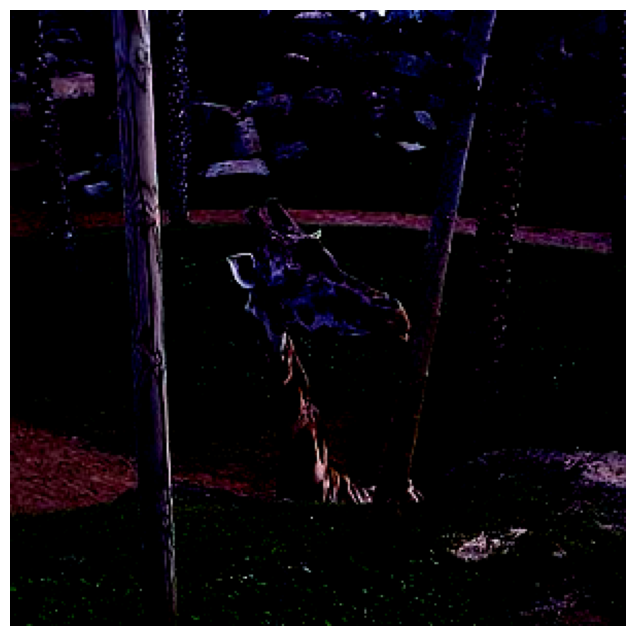

Generated Caption: A giraffe is inside and inside giraffe enclosure. The walls are lined with bark free trees and windows. On the floor is a bunch of yellow hay. The giraffe is spotted and white and brown. There are two large white pillars inside as well.


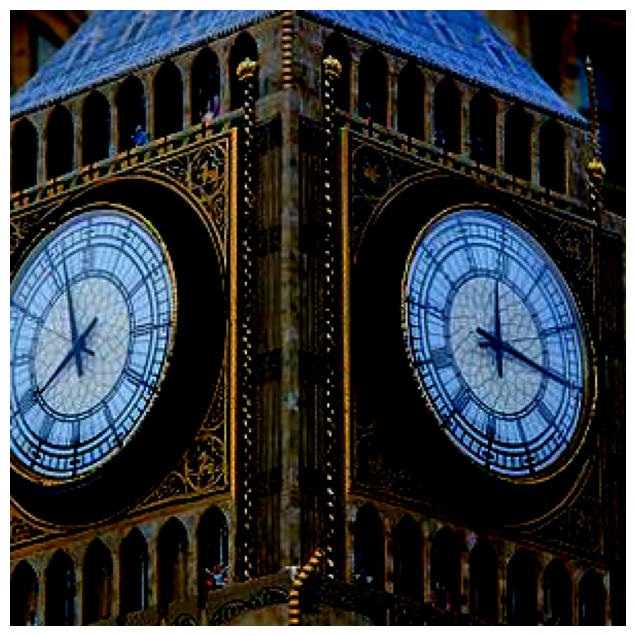

Generated Caption: A fancy tower has clocks on at least two of its sides. There are golden decorations around the clocks as well as on the top level of the tower. The top of the tower is pointy. The clocks have a white face and black hands. The time is 1:30.


In [11]:
#Sample Outputs
model.eval()
num_examples = 2
for i in range(num_examples):
    image, caption = test_dataset[i + 249]
    image = image.unsqueeze(0).cuda()

    # Generate the caption
    outputs = model.generate_caption(image)

    # Display the image
    image = image.squeeze(0).permute(1, 2, 0).cpu().numpy()
    plt.figure(figsize=(8, 8))
    plt.imshow(image)
    plt.axis('off')
    plt.show()

    # Print the generated caption
    print(f"Generated Caption: {outputs}")